# Initialization

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from numpy import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
import statsmodels
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from sklearn.utils import check_array
from scipy import stats
from scipy.special import boxcox1p
from tqdm import tqdm_notebook
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

%matplotlib inline
#style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

#!sudo apt-get install python-sklearn

import warnings
warnings.filterwarnings('ignore')

In [2]:
movies1 = pd.read_csv('movies_metadata.csv')
movies2 = pd.read_csv('movie_metadata.csv')

# Data Cleaning & Preprocessing

In [3]:
print(movies1.shape)
print(movies2.shape)

(45466, 24)
(5043, 28)


In [4]:
movies1.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [5]:
movies2.head(1)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000


Both datasets are amazing but one is massive compared to another. I want to know if I should combine both to get more features but lesser samples which could possibly increase accuracy, or should I use the dataset with 40k and rely on training samples alone. I'll try the former option first.

In [6]:
movies2['imdb_id'] = movies2['movie_imdb_link'].apply(lambda x: x.split('/')[4])
movies = pd.merge(left = movies1, right = movies2, left_on = 'imdb_id', right_on = 'imdb_id')

Since I'm using two datasets, there are overlapping features. I will discard the redundants with lesser data. For example, if one dataset has more genre specification than the other, I will prefer it more. 

Removing null values:

In [7]:
movies.head(1)

,adult,belongs_to_collection,budget_x,genres_x,homepage,id,imdb_id,original_language,original_title,overview,...,num_user_for_reviews,language,country,content_rating,budget_y,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,391.0,English,USA,G,30000000.0,1995.0,1000.0,8.3,1.85,0


In [8]:
print(movies['genres_x'].fillna('[]').apply(literal_eval).apply(lambda x: len([i['name'] for i in x]) if isinstance(x, list) else []).mean())
print(movies['genres_y'].apply(lambda x: len(x.split("|"))).mean())

2.5678881592882865
2.9112476170302903


As evident from above, the genre feature from the second dataset has more data, so I will discard the genre column from the first. I'm not sure if this will help increase the prediction accuracy in anyway, but I'll give it a shot.

Also going to be taking only one genre from the list of genres. This will of course decrease accuracy but I don't know how to incorporate multiple genres into my algorithm. I could one-hot encode them, but that would mean my algorithm would give preference to movies with more listed genres, which is not an indicator of success. 

In [9]:
movies['genre'] = movies['genres_y'].apply(lambda x: x.split("|")[0])

In [10]:
movies['genre'].unique()

array(['Adventure', 'Action', 'Comedy', 'Biography', 'Drama', 'Crime',
       'Documentary', 'Fantasy', 'Sci-Fi', 'Animation', 'Horror',
       'Film-Noir', 'Family', 'Western', 'Thriller', 'Musical', 'Mystery',
       'Romance', 'Music'], dtype=object)

In [11]:
movies.shape

(4721, 53)

In [12]:
'''
one_hot_genres = pd.get_dummies(movies['genre'], prefix = 'category')
one_hot_genre_cols = one_hot_genres.columns
movies = pd.concat([movies, one_hot_genres], axis=1, sort = False)
'''

"\none_hot_genres = pd.get_dummies(movies['genre'], prefix = 'category')\none_hot_genre_cols = one_hot_genres.columns\nmovies = pd.concat([movies, one_hot_genres], axis=1, sort = False)\n"

Another thing that I notice is discrepancies between similar columns, for example the gross/revenue. They seem to differ by a lot. How much? We'll find out. 

In [13]:
(abs(movies['revenue'] - movies['gross']) / (movies['revenue'] + movies['gross']) * 100).mean()

43.07130868751626

43% difference. No thank you. After doing a bit of digging around, I find that the dataset movies2 contained movie revenue for USA alone, while movies1 has the global revenue. What I want is the former, so I will discard the 'revenue' column from movie1 and keep 'gross'.

There's another interesting column, 'belongs_to_collection'. I will binarize, as it makes sense as to conclude that a movie will earn more if it belongs to a collection.

In [14]:
movies['belongs_to_collection'] = movies['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1)

Converting to datetime format for convenience.

In [15]:
months = ['Placeholder', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
movies['release_date'] = movies['release_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
movies['release_month'] = movies['release_date'].apply(lambda x: months[x.month])
movies['release_year'] = movies['release_date'].apply(lambda x: x.year)


Converting to lists:

In [16]:
movies['production_companies'] = movies['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies['production_countries'] = movies['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies['spoken_languages'] = movies['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Plot keywords will help a ton in building movie recommendation systems, but the goal here is to predict the profit of a movie. So it's of no use here. 

In [17]:
columns_to_drop = ['revenue', 'movie_imdb_link', 'genres_x', 'genres_y', 'homepage', 'id', 'imdb_id', 'overview', 
                   'poster_path', 'status', 'tagline', 'movie_title', 'original_language', 'original_title', 'video',
                  'budget_x', 'language', 'country', 'adult', 'plot_keywords', 'aspect_ratio', 'runtime', 'title_year']
                   
movies = movies.drop(columns_to_drop, axis = 1).rename(columns = {'budget_y' : 'budget', 'gross' : 'revenue'})

In [18]:
movies = movies[movies['production_countries'].apply(lambda x: True if 'United States of America' in x else False)]
movies = movies[movies['spoken_languages'].apply(lambda x: True if 'English' in x else False)]

In [19]:
movies.median()

belongs_to_collection        0.000000e+00
popularity                   8.754132e+00
vote_average                 6.200000e+00
vote_count                   3.350000e+02
num_critic_for_reviews       1.250000e+02
duration                     1.050000e+02
director_facebook_likes      5.700000e+01
actor_3_facebook_likes       4.345000e+02
actor_1_facebook_likes       1.000000e+03
revenue                      3.240374e+07
num_voted_users              4.622100e+04
cast_total_facebook_likes    3.924000e+03
facenumber_in_poster         1.000000e+00
num_user_for_reviews         1.910000e+02
budget                       2.300000e+07
actor_2_facebook_likes       6.800000e+02
imdb_score                   6.500000e+00
movie_facebook_likes         2.090000e+02
release_year                 2.005000e+03
dtype: float64

In [20]:
print(movies.shape)
movies = movies.dropna()
#movies = movies.fillna(movies.median())
print(movies.shape)

(3943, 32)
(3358, 32)


# Exploratory Data Analysis & Feature Selection

In [21]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3358 entries, 0 to 4713
Data columns (total 32 columns):
belongs_to_collection        3358 non-null int64
popularity                   3358 non-null object
production_companies         3358 non-null object
production_countries         3358 non-null object
release_date                 3358 non-null datetime64[ns]
spoken_languages             3358 non-null object
title                        3358 non-null object
vote_average                 3358 non-null float64
vote_count                   3358 non-null float64
color                        3358 non-null object
director_name                3358 non-null object
num_critic_for_reviews       3358 non-null float64
duration                     3358 non-null float64
director_facebook_likes      3358 non-null float64
actor_3_facebook_likes       3358 non-null float64
actor_2_name                 3358 non-null object
actor_1_facebook_likes       3358 non-null float64
revenue                      

In [22]:
movies.describe().shape

(8, 18)

In [23]:
movies.describe()

,belongs_to_collection,vote_average,vote_count,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,revenue,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,actor_2_facebook_likes,imdb_score,movie_facebook_likes,release_year
count,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000,3358.000000,3.358000e+03,3.358000e+03,3358.000000,3358.000000,3358.000000,3.358000e+03,3358.000000,3358.000000,3358.000000,3358.000000
mean,0.250744,6.190887,954.145920,169.294223,110.233770,860.966647,824.218285,8135.464562,5.732073e+07,1.104946e+05,12190.299285,1.414532,351.083681,4.103701e+07,2171.393985,6.407058,9568.661108,2003.037522
std,0.433506,0.882913,1448.036597,124.773653,22.353895,3209.121228,1973.656712,15538.326953,7.243680e+07,1.567349e+05,19333.196884,2.099191,423.934717,4.410129e+07,4729.843994,1.055894,21847.848698,9.846291
min,0.000000,0.000000,0.000000,1.000000,37.000000,0.000000,0.000000,0.000000,1.620000e+02,1.030000e+02,0.000000,0.000000,6.000000,2.180000e+02,0.000000,1.600000,0.000000,1929.000000
25%,0.000000,5.700000,138.000000,78.000000,96.000000,11.000000,230.250000,807.250000,1.220310e+07,2.138275e+04,2172.250000,0.000000,116.000000,1.200000e+07,435.250000,5.800000,0.000000,1999.000000
50%,0.000000,6.200000,416.000000,140.000000,106.000000,65.000000,462.500000,2000.000000,3.395762e+07,5.703900e+04,4529.000000,1.000000,217.000000,2.600000e+07,723.000000,6.500000,245.000000,2004.000000
75%,1.000000,6.800000,1120.500000,226.000000,120.000000,241.000000,719.750000,13000.000000,7.266003e+07,1.353745e+05,16962.500000,2.000000,417.500000,5.500000e+07,1000.000000,7.100000,11000.000000,2010.000000
max,1.000000,9.300000,14075.000000,813.000000,330.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,3.000000e+08,137000.000000,9.300000,349000.000000,2016.000000


The extremely left skewed distribution is called a pareto distribution.

Text(0.5, 0, 'Revenue')

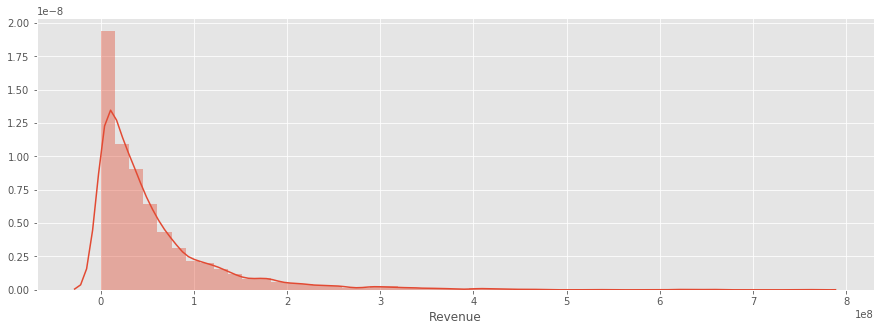

In [24]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.distplot(movies['revenue'])
plt.xlabel('Revenue')
#fig.savefig('revenue_dist.png', format='png', dpi=1200)
#files.download("revenue_dist.png") 

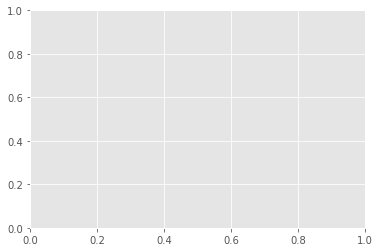

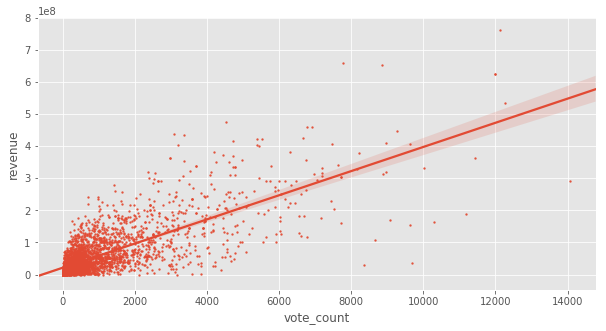

In [25]:
from pylab import figure, text, scatter, show
fix, ax = plt.subplots()
plt.figure(figsize = (10, 5))
sns.regplot(x = movies['vote_count'], y = movies['revenue'], scatter_kws = {'s':2})
sns.despine(top = True, right = True)
#text(0.2, 1.0, 'Correlation: ' + str(np.corrcoef(movies['vote_count'], movies['revenue'])[0,1].round(4)), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
#plt.savefig('corr.png', dpi = 1200)
#files.download('corr.png')

In [26]:
np.corrcoef(movies['vote_count'], movies['revenue'])[0, 1]

0.7514927348521296

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69]), <a list of 70 Text xticklabel objects>)

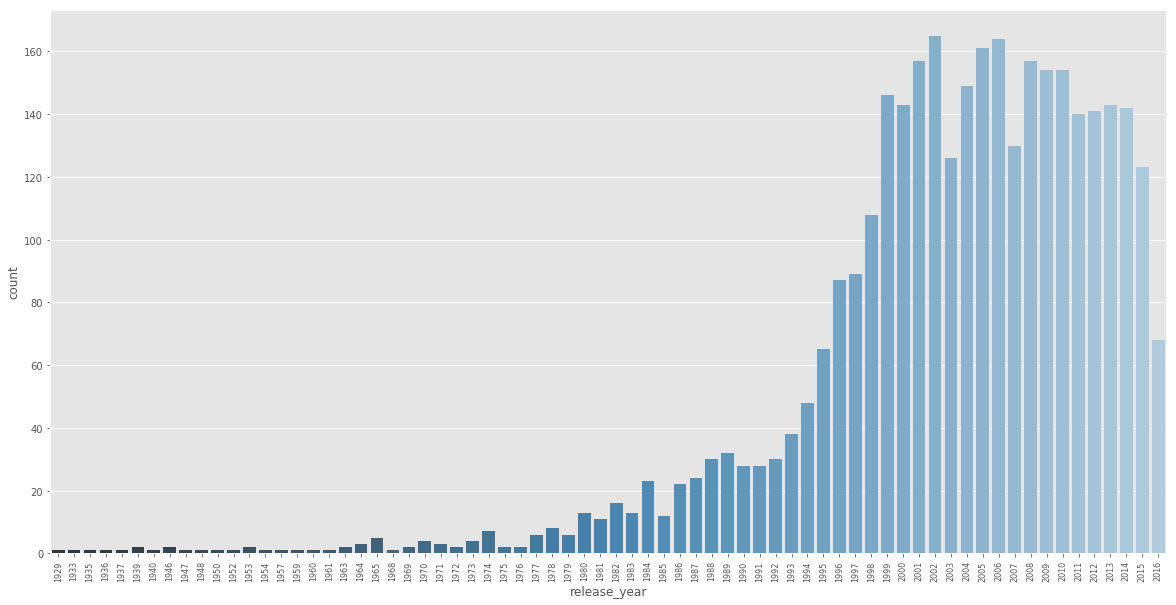

In [27]:
plt.figure(figsize = (20, 10))
sns.countplot(x = 'release_year', data = movies, palette=("Blues_d"))
plt.xticks(rotation = 90, fontsize=8)
#plt.savefig('count_of_movies_each_year.png', dpi = 1200)
#files.download('count_of_movies_each_year.png')

Movies released before 1990 will not be taken into consideration as only a few movies are released.

In [28]:
pd.DataFrame(movies.groupby('release_year').sum()['budget'])

,budget
release_year,
1929,3.790000e+05
1933,4.390000e+05
1935,6.090000e+05
1936,1.500000e+06
1937,2.000000e+06
1939,6.777000e+06
1940,2.600000e+06
1946,1.010000e+07
1947,2.300000e+06


In [29]:
movies_after_1995 = movies[(movies['release_year'] >= 1995) & (movies['release_year'] != 2017)]

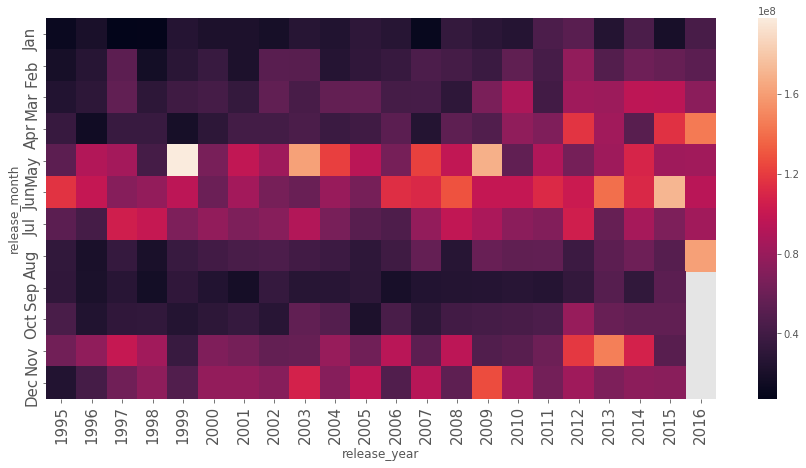

In [30]:
movies_numerical = movies_after_1995.select_dtypes(include = 'number').dropna()
pt = movies_after_1995.pivot_table(index = 'release_month', columns = 'release_year', values = 'revenue').reindex(index = months[1:])
fig, ax = plt.subplots(figsize=(15, 7)) 
ax.tick_params(axis="x", labelsize = 15)
ax.tick_params(axis="y", labelsize = 15)
sns.heatmap(pt)
#plt.savefig('heatmap.png', dpi = 1200)
#files.download('heatmap.png')

In [31]:
top_10_directors = list(movies.groupby('director_name').sum().sort_values(by = 'revenue', ascending = False).head(10).reset_index()['director_name'])
top_10_directors_revenue = list(movies.groupby('director_name').sum().sort_values(by = 'revenue', ascending = False).head(10).reset_index()['revenue'])
directors_and_revenue_dict = dict(zip(top_10_directors, top_10_directors_revenue))
movies_numerical['top_director'] = movies['director_name'].apply(lambda x: 1 if x in top_10_directors else 0)

In [32]:
movies.groupby('director_name').sum().sort_values(by = 'revenue', ascending = False).head(10).reset_index()[['director_name', 'revenue']]

,director_name,revenue
0,Steven Spielberg,4.114233e+09
1,Peter Jackson,2.286919e+09
2,Michael Bay,2.231243e+09
3,Tim Burton,2.071275e+09
4,Sam Raimi,2.049549e+09
5,James Cameron,1.948126e+09
6,Christopher Nolan,1.813228e+09
7,George Lucas,1.741418e+09
8,Joss Whedon,1.730887e+09
9,Robert Zemeckis,1.619309e+09


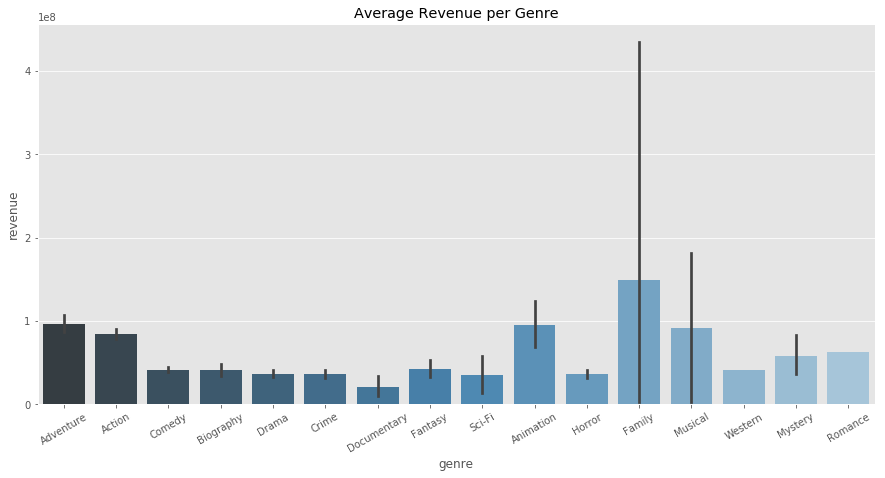

In [33]:
fig, ax = plt.subplots(figsize=(15, 7)) 
ax = sns.barplot(x = 'genre', y = 'revenue', data = movies, palette=("Blues_d"))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('Average Revenue per Genre')
plt.show()
#plt.savefig('avg_revenue_genre.png', format = 'png', dpi = 1200)
#files.download('avg_revenue_genre.png')
#movies = movies.drop('genre', axis = 1)

In [34]:
movies_numerical['action_or_adventure'] = movies['genre'].apply(lambda x: 1 if x == 'Action' or x == 'Adventure' else 0)

## Backward Elimination

Using a significance level (SL) of 0.05 (the industry standard), I will remove all features with a p-value greater than the SL, although one at a time. Each iteration, the highest p-value is removed.

Afterwards, I recompute the p-values again and repeat until no features have p-values above SL.

Also, below code is needed because statsmodel doesn't include the column of ones by default.

In [35]:
X = movies_numerical.loc[:, movies_numerical.columns != 'revenue']
Y = movies_numerical['revenue']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 20)
model = LinearRegression(fit_intercept = True)
model.fit(X_train, Y_train)#, sample_weight = self.sample_weight)
intercept = model.intercept_
print(intercept)

813787443.4240371


In [36]:
movies_with_intercept = movies_numerical.copy()
#movies_with_ones = statsmodels.tools.tools.add_constant(movies_with_ones)
movies_with_intercept ['intercept'] = intercept
#movies_with_ones['const'] = 1
X = movies_with_intercept .loc[:, movies_with_intercept .columns != 'revenue']
Y = movies_with_intercept ['revenue']
insignificant_cols = ['facenumber_in_poster', 'num_critic_for_reviews', 'release_year']
X = X.drop(insignificant_cols, axis = 1)
regressor_OLS = sm.OLS(endog = Y, exog = X, hasconst = True).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     509.3
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        23:53:35   Log-Likelihood:                -54918.
No. Observations:                2912   AIC:                         1.099e+05
Df Residuals:                    2895   BIC:                         1.100e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
belongs_to_collection       2.26e+07   1.89e+06     11.944      0.000    1.89e+07    2.63e+07
vote_average               7.328e+06   1.89e+06      3.881      0.000    3.63e+06     1.1e+07
vote_count                 3.181e+04   1451.774     21.909      0.000     2.9e+04    3.47e+04
duration                  -1.187e+05   4.36e+04     -2.720      0.007   -2.04e+05   -3.31e+04
director_facebook_likes   -1418.4105    255.132     -5.560      0.000   -1918.670    -918.151
actor_3_facebook_likes    -5949.3429    978.993     -6.077      0.000   -7868.936   -4029.749
actor_1_facebook_likes    -5024.5994    592.564     -8.479      0.000   -6186.489   -3862.710
num_voted_users             -37.6561     13.431     -2.804      0.005     -63.991     -11.322
cast_total_facebook_likes  4927.6744    591.545      8.330      0.000    3767.783    6087.566
num_user_for_reviews       1.152e+04   2797.639      4.119      0.000    6038.338     1.7e+04
budget                        0.5461      0.023     23.411      0.000       0.500       0.592
actor_2_facebook_likes    -4896.6107    626.430     -7.817      0.000   -6124.905   -3668.317
imdb_score                -3.554e+06    1.6e+06     -2.223      0.026   -6.69e+06   -4.19e+05
movie_facebook_likes       -514.4919     44.593    -11.537      0.000    -601.929    -427.054
top_director               3.654e+07   4.79e+06      7.628      0.000    2.72e+07    4.59e+07
action_or_adventure        -1.05e+07   1.77e+06     -5.936      0.000    -1.4e+07   -7.03e+06
intercept                    -0.0096      0.008     -1.210      0.226      -0.025       0.006
==============================================================================
Omnibus:                     1079.965   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11922.721
Skew:                           1.437   Prob(JB):                         0.00
Kurtosis:                      12.487   Cond. No.                     5.60e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.6e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Omnibus/Prob(Omnibus) – a test of the skewness and kurtosis of the residual (characteristic #2). We hope to see a value close to zero which would indicate normalcy. The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here. In this case Omnibus is relatively low and the Prob (Omnibus) is relatively high so the data is somewhat normal, but not altogether ideal. A linear regression approach would probably be better than random guessing but likely not as good as a nonlinear approach.

Skew – a measure of data symmetry. We want to see something close to zero, indicating the residual distribution is normal. Note that this value also drives the Omnibus. This result has a small, and therefore good, skew.

Kurtosis – a measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers.

Durbin-Watson – tests for homoscedasticity (characteristic #3). We hope to have a value between 1 and 2. In this case, the data is close, but within limits.

Jarque-Bera (JB)/Prob(JB) – like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a confirmation of the Omnibus test. In this case we do.

Condition Number – This test measures the sensitivity of a function's output as compared to its input (characteristic #4). When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30. In this case we are well below 30, which we would expect given our model only has two variables and one is a constant.

In [37]:
movies_be = movies_numerical.copy().drop(insignificant_cols, axis = 1)

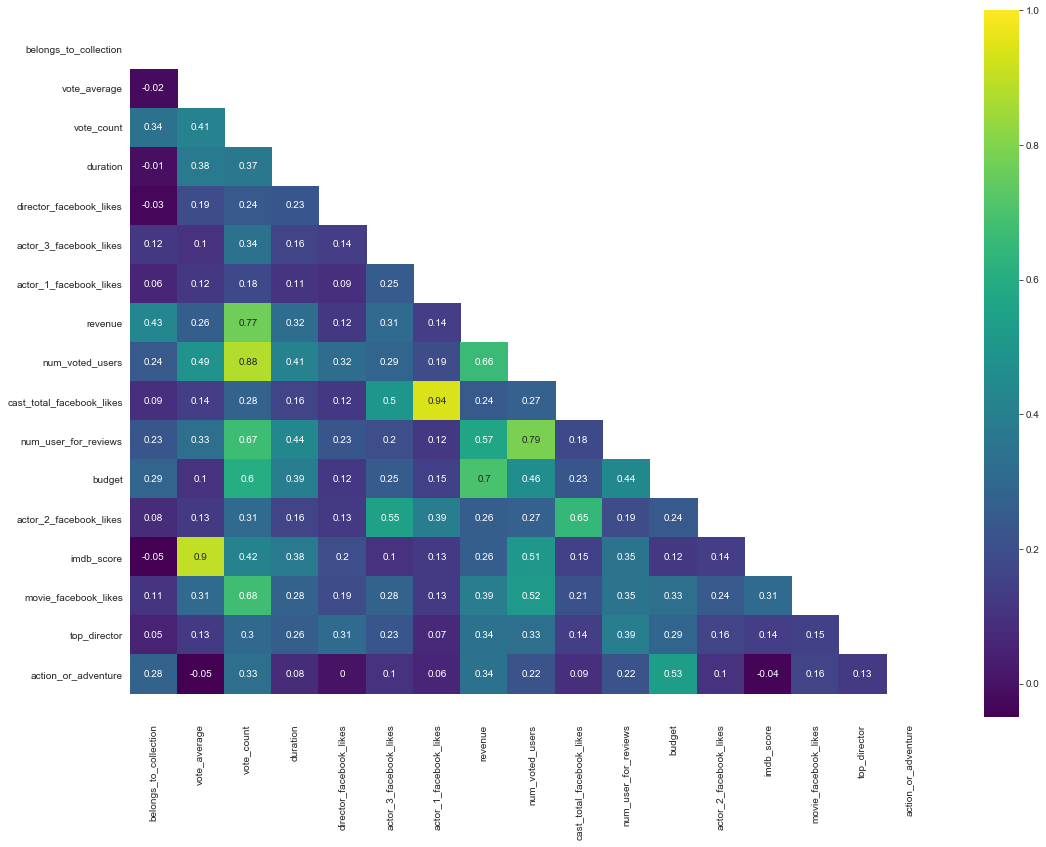

In [38]:
plt.figure(figsize = (18, 13))
sns.set_style("white")

corr_df = movies_be.copy()
corr = corr_df.corr().round(2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#sns.heatmap(corr, annot = True, cmap = 'viridis', mask = mask)
heatmap = sns.heatmap(corr, annot = True, cmap = 'viridis', mask = mask)
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.6, top - 0.5)
fig = heatmap.get_figure()
#fig.savefig('heatmap.png', format = 'png', dpi = 1200)
plt.show()

## Feature Selection Stuff

### Select k best / Univariate Selection

In [39]:
from sklearn.feature_selection import SelectKBest, chi2

X = movies_be.copy().loc[:, movies_be.columns != 'revenue']
y = movies_be.copy()['revenue']

bestfeatures = SelectKBest(score_func=chi2, k=9)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(9,'Score')) 

k_best_cols = list(featureScores.nlargest(9,'Score').iloc[:, 0])
k_best_cols.append('revenue')

                        Specs         Score
10                     budget  1.385553e+11
7             num_voted_users  5.994871e+08
13       movie_facebook_likes  1.483301e+08
8   cast_total_facebook_likes  9.281176e+07
6      actor_1_facebook_likes  9.042603e+07
4     director_facebook_likes  3.489936e+07
11     actor_2_facebook_likes  3.058759e+07
5      actor_3_facebook_likes  1.452063e+07
2                  vote_count  6.464257e+06


### Feature Importance

[0.01470752 0.07326097 0.07651357 0.07766461 0.07487516 0.07774061
 0.07112115 0.07791485 0.07454699 0.07836348 0.07573893 0.0770569
 0.075152   0.0598933  0.00202457 0.0134254 ]


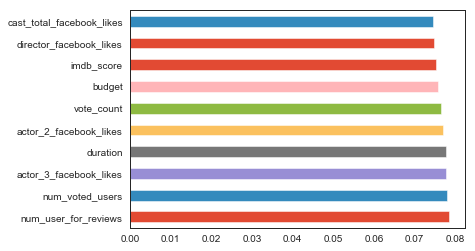

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X,y)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

feature_important_cols = list(feat_importances.nlargest(10).keys())
feature_important_cols.append('revenue')

# Machine Learning

Note to self: Click [here](https://pastebin.com/LNMqJmJi) for working Predictor class dated 4/8/2019

Linear Regression.**Note to self: Using features with a correlation coefficient in the range 0.1 to 0.9 yielded no changes in accuracies in comparison to using the whole dataset.**

Note to self: Box-Cox and Log transforming the dependent variable gave a decrease/no change in accuracy.

In [41]:
#results_df.drop(results_df.index, inplace=True)

## Linear Regression

Normalization is not needed but is done for easy interpretation of the error metrics. Standardization is also not required here. 

In [42]:
from sklearn.preprocessing import PowerTransformer

dataset = movies_be.copy().drop(['action_or_adventure', 'top_director'], axis = 1)

cv_sets = 10
corrs = []
iterations = 100
normalize = True
results_list = ['Linear Regression']

if normalize:
    for column in dataset.columns:
      dataset[column] = ((dataset[column]) - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

X = dataset.loc[:, dataset.columns != 'revenue']
y = dataset['revenue']

model = LinearRegression(fit_intercept = True)
model.fit(X, y)

mse_mean = cross_val_score(model, X, y, cv = cv_sets, scoring = 'neg_mean_squared_error').mean()
mae_mean = cross_val_score(model, X, y, cv = cv_sets, scoring = 'neg_mean_absolute_error').mean()
r2_mean = cross_val_score(model, X, y, cv = cv_sets, scoring = 'r2').mean()

# Calculate correlation between predicted and actual for a number of iterations and get the average

for i in tqdm_notebook(range(iterations), total = iterations, unit = 'iteration'):
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  model = LinearRegression(fit_intercept = True)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  corrs.append(np.corrcoef(y_test, y_pred)[0, 1])

results_list.append(sum(corrs)/iterations)
results_list.append(abs(mae_mean))
results_list.append(abs(mse_mean))
results_list.append(sqrt(abs(mse_mean)))
results_list.append(abs(r2_mean))

results_df = pd.DataFrame([results_list], columns = ['Algorithm', 'Correlation', 'MAE', 'MSE', 'RMSE', 'R2'])
results_df

,Algorithm,Correlation,MAE,MSE,RMSE,R2
0,Linear Regression,0.848596,0.032815,0.002603,0.051022,0.70225


## Support Vector Regression

Note: When using standardization, the 

In [43]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

corrs = []
mses = []
maes = []
r2s = []
rmses = []
results_list = ['Support Vector']

for i in range(100):
  dataset = movies_be.copy()
  cv_sets = 10
  normalize = True
  standardize = False


  if normalize:
      for column in dataset.columns:
        dataset[column] = ((dataset[column]) - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

  X = dataset.loc[:, dataset.columns != 'revenue']
  y = dataset['revenue']

  if standardize:
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X = sc_X.fit_transform(X)
    y = sc_y.fit_transform(y.values.reshape(-1, 1))

  X_train, X_test, y_train, y_test = train_test_split(X, y) #, test_size = 0.2)

  model = SVR(kernel = 'linear')
  model.fit(X_train, y_train)

  if standardize:
    y_pred = sc_y.inverse_transform(model.predict(sc_X.transform(X_test)))
  else:
    y_pred = model.predict(X_test)
  
  
  mses.append(mean_squared_error(y_test, y_pred)) 
  maes.append(mean_absolute_error(y_test, y_pred))
  r2s.append(r2_score(y_test, y_pred))
  corrs.append(np.corrcoef(y_test, y_pred)[0, 1])
  rmses.append(sqrt(abs(mean_squared_error(y_test, y_pred))))


results_list.append(np.mean(corrs))
results_list.append(abs(np.mean(maes)))
results_list.append(abs(np.mean(mses)))
results_list.append(sqrt(abs(np.mean(rmses))))
results_list.append(abs(np.mean(r2s)))

results_df.loc[len(results_df)] = results_list

## Decision Tree Regression

In [44]:

from sklearn.tree import DecisionTreeRegressor

dataset = movies_be.copy()
cv_sets = 10
corrs = []
results_list = ['Decision Tree']
iterations = 100
normalize = True

X = dataset.loc[:, dataset.columns != 'revenue']
y = dataset['revenue']

if normalize:
    for column in dataset.columns:
      dataset[column] = ((dataset[column]) - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

model = DecisionTreeRegressor()
model.fit(X, y)

mse_mean = cross_val_score(model, X, y, cv = cv_sets, scoring = 'neg_mean_squared_error').mean()
mae_mean = cross_val_score(model, X, y, cv = cv_sets, scoring = 'neg_mean_absolute_error').mean()
r2_mean = cross_val_score(model, X, y, cv = cv_sets, scoring = 'r2').mean()

for i in tqdm_notebook(range(iterations), total = iterations, unit = 'iteration'):
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  model = DecisionTreeRegressor()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  corrs.append(np.corrcoef(y_test, y_pred)[0, 1])

results_list.append(np.mean(corrs))
results_list.append(abs(np.mean(maes)))
results_list.append(abs(np.mean(mses)))
results_list.append(sqrt(abs(np.mean(rmses))))
results_list.append(abs(np.mean(r2s)))

results_df.loc[len(results_df)] = results_list

## Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor

dataset = movies_be.copy()
cv_sets = 10
corrs = []
results_list = ['Random Forest']
iterations = 1
normalize = True
estimators = 100

X = dataset.loc[:, dataset.columns != 'revenue']
y = dataset['revenue']

if normalize:
    for column in dataset.columns:
      dataset[column] = ((dataset[column]) - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

model = RandomForestRegressor(n_estimators = estimators)
model.fit(X, y)

mse_mean = cross_val_score(model, X, y, cv = cv_sets, scoring = 'neg_mean_squared_error').mean().round(4)
mae_mean = cross_val_score(model, X, y, cv = cv_sets, scoring = 'neg_mean_absolute_error').mean().round(4)
r2_mean = cross_val_score(model, X, y, cv = cv_sets, scoring = 'r2').mean().round(4)

for i in tqdm_notebook(range(iterations), total = iterations, unit = 'iteration'):
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  model = RandomForestRegressor(n_estimators = estimators)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  corrs.append(np.corrcoef(y_test, y_pred)[0, 1])

print('Corr: \t' + str((sum(corrs)/iterations).round(4)))
print('MAE: \t'+ str(abs(mae_mean).round(4)))
print('MSE: \t' + str(abs(mse_mean).round(4))) 
print('RMSE: \t' + str(sqrt(abs(mse_mean)).round(4)))
print('R2: \t' + str(abs(r2_mean).round(4)))

#print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), dataset.columns), reverse=True))

results_list.append(sum(corrs)/iterations)
results_list.append(abs(mae_mean))
results_list.append(abs(mse_mean))
results_list.append(sqrt(abs(mse_mean)))
results_list.append(abs(r2_mean))
results_df.loc[len(results_df)] = results_list


Corr: 	0.8688
MAE: 	0.0317
MSE: 	0.0025
RMSE: 	0.05
R2: 	0.7128


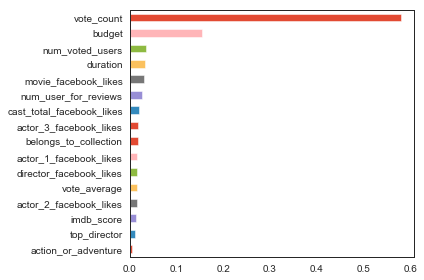

In [46]:
feat_importances = pd.Series(model.feature_importances_, index = X.columns)
fig = feat_importances.nsmallest(len(X.columns)).plot(kind='barh').get_figure()
plt.tight_layout()
#fig.savefig('feat_importances.png', format='png', dpi=1200)
#files.download("feat_importances.png") 

## Ridge Regression

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

dataset = movies_be.copy()

cv_sets = 10
normalize = False
results_list = ['Ridge']

if normalize:
    for column in dataset.columns:
      dataset[column] = ((dataset[column]) - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

X = dataset.loc[:, dataset.columns != 'revenue']
y = dataset['revenue']
parameters = {'alpha' : [1e-15, 1e-10, 1e-8, 18-4, 1e-3, 1e-2, 1, 5, 10, 20]}
scoring = {'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2' : 'r2_score'}

model = Ridge()

regressor_mse = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv = cv_sets)
regressor_mse.fit(X, y)

regressor_mae = GridSearchCV(model, parameters, scoring = 'neg_mean_absolute_error', cv = cv_sets)
regressor_mae.fit(X, y)

regressor_r2 = GridSearchCV(model, parameters, scoring = 'r2', cv = cv_sets)
regressor_r2.fit(X, y)

results_list.append(np.nan)
results_list.append(abs(np.mean(maes)))
results_list.append(abs(np.mean(mses)))
results_list.append(sqrt(abs(np.mean(rmses))))
results_list.append(abs(np.mean(r2s)))

In [48]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

dataset = movies_be.copy()
iterations = 100
corrs = []

cv_sets = 10
normalize = True

if normalize:
    for column in dataset.columns:
      dataset[column] = ((dataset[column]) - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

X = dataset.loc[:, dataset.columns != 'revenue']
y = dataset['revenue']
parameters = {'alpha' : [1e-15, 1e-10, 1e-8, 18-4, 1e-3, 1e-2, 1, 5, 10, 20]}
scoring_metrics = {'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2' : 'r2'}

for i in tqdm_notebook(range(iterations), total = iterations, unit = 'iteration'):
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  model = Ridge()
  regressor = GridSearchCV(model, parameters, cv = cv_sets)
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  corrs.append(np.corrcoef(y_test, y_pred)[0, 1])

results_list[1] = sum(corrs)/iterations
results_df.loc[len(results_df)] = results_list

## Lasso Regression

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

dataset = movies_be.copy()

cv_sets = 10
normalize = True
results_list = ['Lasso']

if normalize:
    for column in dataset.columns:
      dataset[column] = ((dataset[column]) - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

X = dataset.loc[:, dataset.columns != 'revenue']
y = dataset['revenue']
parameters = {'alpha' : [1e-15, 1e-10, 1e-8, 18-4, 1e-3, 1e-2, 1, 5, 10, 20]}

#model = Lasso(tol=1)
model = Lasso()

regressor_mse = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv = cv_sets)
regressor_mse.fit(X, y)

regressor_mae = GridSearchCV(model, parameters, scoring = 'neg_mean_absolute_error', cv = cv_sets)
regressor_mae.fit(X, y)

regressor_r2 = GridSearchCV(model, parameters, scoring = 'r2', cv = cv_sets)
regressor_r2.fit(X, y)

results_list.append(np.nan)
results_list.append(abs(np.mean(maes)))
results_list.append(abs(np.mean(mses)))
results_list.append(sqrt(abs(np.mean(rmses))))
results_list.append(abs(np.mean(r2s)))

To calculate correlation. Don't run again please. The results are almost always the same

In [50]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

dataset = movies_be.copy()
iterations = 100
corrs = []

cv_sets = 10
normalize = True

if normalize:
    for column in dataset.columns:
      dataset[column] = ((dataset[column]) - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

X = dataset.loc[:, dataset.columns != 'revenue']
y = dataset['revenue']
parameters = {'alpha' : [1e-15, 1e-10, 1e-8, 18-4, 1e-3, 1e-2, 1, 5, 10, 20]}
scoring_metrics = {'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2' : 'r2'}

for i in tqdm_notebook(range(iterations), total = iterations, unit = 'iteration'):
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  model = Lasso()
  regressor = GridSearchCV(model, parameters, cv = cv_sets)
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  corrs.append(np.corrcoef(y_test, y_pred)[0, 1])

results_list[1] = sum(corrs)/iterations
results_df.loc[len(results_df)] = results_list


In [51]:
results_df

,Algorithm,Correlation,MAE,MSE,RMSE,R2
0,Linear Regression,0.848596,0.032815,0.002603,0.051022,0.702250
1,Support Vector,0.840365,0.043034,0.003219,0.238074,0.650731
2,Decision Tree,0.752134,0.043034,0.003219,0.238074,0.650731
3,Random Forest,0.868772,0.031700,0.002500,0.050000,0.712800
4,Ridge,0.854340,0.043034,0.003219,0.238074,0.650731
5,Lasso,0.851810,0.043034,0.003219,0.238074,0.650731


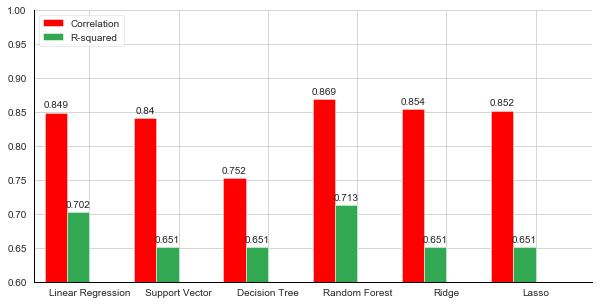

In [52]:
pos = list(range(len(results_df['Correlation']))) 
width = 0.25 
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,5))

rects1 = plt.bar(pos, results_df['Correlation'], width, color = '#ff0000', label = results_df['Algorithm'][0])
rects2 = plt.bar([p + width for p in pos], results_df['R2'], width, color = '#32a852', label = results_df['Algorithm'][1]) 

plt.bar(pos, results_df['Correlation'], width, color = '#ff0000', label = results_df['Algorithm'][0])
plt.bar([p + width for p in pos], results_df['R2'], width, color = '#32a852', label = results_df['Algorithm'][1]) 

#ax.set_ylabel('Score')
#ax.set_title('Correlation and R-squared comparison')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(results_df['Algorithm'])

plt.xlim(min(pos)-width, max(pos)+width*4)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
plt.ylim([0.6, 1])
#plt.xticks(rotation = 45)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height().round(3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
sns.despine(top = True, right = True)
plt.legend(['Correlation', 'R-squared'], loc='upper left')
plt.show()

#fig.savefig('corrandr2.png', format = 'png', dpi = 1200)
#files.download('corrandr2.png')

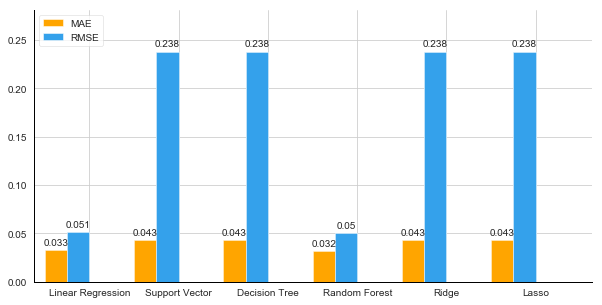

In [53]:
pos = list(range(len(results_df['MAE']))) 
width = 0.25 
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,5))

rects1 = plt.bar(pos, results_df['MAE'], width, color = '#ffa500', label = results_df['Algorithm'][0])
rects2 = plt.bar([p + width for p in pos], results_df['RMSE'], width, color = '#34a1eb', label = results_df['Algorithm'][1]) 

plt.bar(pos, results_df['MAE'], width, color = '#ffa500', label = results_df['Algorithm'][0])
plt.bar([p + width for p in pos], results_df['RMSE'], width, color = '#34a1eb', label = results_df['Algorithm'][1]) 
#ax.set_ylabel('Score')
#ax.set_title('Error metrics comparison')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(results_df['Algorithm'])

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(results_df['MAE'] + results_df['RMSE'])] )
#plt.xticks(rotation = 45)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height().round(3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
sns.despine(top = True, right = True)
plt.legend(['MAE', 'RMSE'], loc='upper left')
plt.show()